In [1]:
%load_ext lab_black

In [2]:
import requests
import json
import os
import pathlib
import time
import bs4
import sqlite3
import newspaper
import spacy

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from IPython.display import clear_output
from urllib3.exceptions import LocationParseError
from multiprocessing import Pool
from math import floor, ceil
from fuzzywuzzy import fuzz, process
from subreddit_sql import create_connection
from unidecode import unidecode
from spacytextblob.spacytextblob import SpacyTextBlob
from itertools import islice

First, the data must be loaded in from the previous notebook. Here we note that the text being used in this analysis is from online articles, *not* text posts on reddit. As such, we have to be wary of certain arsty choices the journalist (or their editors) might make, i.e. the myriad variants of unicode apostrophes which might look better in the articles font but may not be recognized as punctuation by the techniques employed below. The library unidecode solves this in a single function, and will turn all characters present into ASCII.

In [3]:
onion_df = pd.read_csv("../data/duplicates_removed/theonion.csv")
not_onion_df = pd.read_csv("../data/duplicates_removed/nottheonion.csv")

onion_df["article_text"] = onion_df["article_text"].apply(unidecode)
not_onion_df["article_text"] = not_onion_df["article_text"].apply(unidecode)

I elected to use the spaCy library for text processing, as its tokenization process automatically recognizes common bigrams (such as New York) and treats them as a single token. Furthermore, spaCy provides part-of-speech and sentiment information for each token it identifies, so that a net-bias can be explored if one is present. To make use of this, we declare a spacy nlp object.

In [4]:
nlp = spacy.load("en_core_web_lg")
nlp.add_pipe("spacytextblob")  # textblob is added for sentiment

# Token Count EDA 

First, to get an idea of what the article content distributions look like, the posts will be looped through and the length of the article in characters, words, and sentences will be calculated, as well as the number of unique tokens and lemmas as defined by spaCy. In this analysis, I chose to lemmatize instead of stem the words due to its more advanced performance at the cost of speed.

In [5]:
N = len(onion_df)
M = len(not_onion_df)

article_length = []
num_sentences = []
num_tokens = []
num_unique_tokens = []
num_unique_lemmas = []

for n, article in enumerate(onion_df["article_text"]):
    doc = nlp(article)

    article_length.append(len(article))
    num_sentences.append(len(list(doc.sents)))
    num_tokens.append(len(list(doc)))
    num_unique_tokens.append(len(np.unique(list(doc))))
    num_unique_lemmas.append(len(np.unique([token.lemma_ for token in doc])))

    clear_output(wait=True)
    print(f"Onions iterated: {n + 1}/{N}\nNot Onions Iterated: {0}/{M}")

onion_df["article_length"] = article_length
onion_df["num_tokens"] = num_tokens
onion_df["num_sentences"] = num_sentences
onion_df["num_unique_tokens"] = num_unique_tokens
onion_df["num_unique_lemmas"] = num_unique_lemmas

article_length = []
num_sentences = []
num_tokens = []
num_unique_tokens = []
num_unique_lemmas = []

for m, article in enumerate(not_onion_df["article_text"]):
    doc = nlp(article)

    article_length.append(len(article))
    num_sentences.append(len(list(doc.sents)))
    num_tokens.append(len(list(doc)))
    num_unique_tokens.append(len(np.unique(list(doc))))
    num_unique_lemmas.append(len(np.unique([token.lemma_ for token in doc])))

    clear_output(wait=True)
    print(f"Onions iterated: {N}/{N}\nNot Onions Iterated: {m + 1}/{M}")

not_onion_df["article_length"] = article_length
not_onion_df["num_tokens"] = num_tokens
not_onion_df["num_sentences"] = num_sentences
not_onion_df["num_unique_tokens"] = num_unique_tokens
not_onion_df["num_unique_lemmas"] = num_unique_lemmas

Onions iterated: 11699/11699
Not Onions Iterated: 25069/25069


In [6]:
onion_df.describe()

,score,article_length,num_tokens,num_sentences,num_unique_tokens,num_unique_lemmas
count,11608.000000,11699.000000,11699.000000,11699.000000,11699.000000,11699.000000
mean,80.993367,1340.433370,268.358407,10.142918,268.358407,138.005556
std,463.273100,1674.120158,334.502209,13.394034,334.502209,105.776112
min,1.000000,43.000000,11.000000,1.000000,11.000000,10.000000
25%,1.000000,505.000000,104.000000,5.000000,104.000000,78.000000
50%,4.000000,1078.000000,212.000000,6.000000,212.000000,129.000000
75%,28.000000,1412.000000,273.000000,9.000000,273.000000,159.000000
max,23586.000000,100091.000000,19371.000000,577.000000,19371.000000,3688.000000


In [7]:
not_onion_df.describe()

,score,article_length,num_tokens,num_sentences,num_unique_tokens,num_unique_lemmas
count,25069.000000,25069.000000,25069.000000,25069.000000,25069.000000,25069.000000
mean,1354.711596,2460.316526,492.896206,23.925127,492.896206,200.743827
std,5400.425112,2890.102900,566.035661,27.141263,566.035661,145.697243
min,26.000000,15.000000,5.000000,1.000000,5.000000,5.000000
25%,46.000000,1042.000000,210.000000,11.000000,210.000000,113.000000
50%,92.000000,1884.000000,381.000000,19.000000,381.000000,178.000000
75%,306.000000,3062.000000,615.000000,30.000000,615.000000,254.000000
max,92535.000000,100096.000000,20537.000000,1878.000000,20537.000000,3408.000000


Given the numerical stats for each subreddit, there are clearly some errors going on. First and foremost, it is *highly* unlikely that any of these articles are actually 100,000 characters long, so this is almost certainly an error in parsing the webpage. Secondly, there are articles in both tables which contain only a single sentence. This hardly qualifies as an article if it is one, but this is also likely a webscraping error. Therefore, before any further inspection, the databases will be filtered for posts containing no less than 250 characters, and no more than 7500. These boundaries are fairly arbitrary, but they ensure the articles contain at least a few sentences while being less than a novel. Additionally, in this step we will cut down the r/nottheonion table to be exactly the same size as the r/theonion table, with the best scoring posts being kept.

In [8]:
onion_df = onion_df[
    (onion_df["article_length"] > 250) & (onion_df["article_length"] < 7500)
]

In [9]:
not_onion_df = (
    not_onion_df[
        (not_onion_df["article_length"] > 250) & (not_onion_df["article_length"] < 7500)
    ]
    .sort_values(by="score", ascending=False)
    .iloc[0 : len(onion_df)]
)

In [10]:
onion_df.describe()

,score,article_length,num_tokens,num_sentences,num_unique_tokens,num_unique_lemmas
count,9668.000000,9736.000000,9736.000000,9736.000000,9736.000000,9736.000000
mean,80.647290,1553.333915,310.596035,11.313476,310.596035,160.274753
std,387.468406,1160.729250,239.723454,11.082607,239.723454,85.409901
min,1.000000,251.000000,46.000000,1.000000,46.000000,36.000000
25%,1.000000,929.000000,185.000000,6.000000,185.000000,115.000000
50%,5.000000,1164.000000,227.000000,7.000000,227.000000,137.000000
75%,31.000000,1568.000000,302.000000,12.000000,302.000000,170.000000
max,16521.000000,7428.000000,1596.000000,143.000000,1596.000000,623.000000


In [11]:
not_onion_df.describe()

,score,article_length,num_tokens,num_sentences,num_unique_tokens,num_unique_lemmas
count,9736.000000,9736.000000,9736.000000,9736.000000,9736.000000,9736.000000
mean,3051.875719,2344.224630,471.621508,23.269823,471.621508,200.880341
std,7886.959906,1487.220861,297.149927,14.881702,297.149927,95.515251
min,116.000000,251.000000,25.000000,1.000000,25.000000,17.000000
25%,187.000000,1257.750000,253.000000,13.000000,253.000000,130.000000
50%,405.000000,1994.000000,405.000000,20.000000,405.000000,186.000000
75%,1888.750000,3085.750000,619.000000,30.250000,619.000000,256.000000
max,92535.000000,7479.000000,1778.000000,118.000000,1778.000000,596.000000


There are some differences in the descriptive statistics between the satirical and non-satirical articles. For example, the mean length in sentences is over twice as long for articles submitted to r/nottheonion. This is somewhat expected, as The Onion has a tendency to publish single paragraphs to deliver the joke and little more.

In [12]:
onion_df["satire"] = 1
not_onion_df["satire"] = 0

corpus = (
    pd.concat([onion_df, not_onion_df], axis=0)
    .drop(columns=["score"])
    .reset_index(drop=True)
)

total_onion_tokens = corpus[corpus["satire"] == 1]["num_tokens"].sum()
total_nonion_tokens = corpus[corpus["satire"] == 0]["num_tokens"].sum()

print(
    f"The satirical articles contain a total of {total_onion_tokens} tokens\nThe non-satirical articles contain a total of {total_nonion_tokens}\nThe full corpus contains {total_nonion_tokens + total_onion_tokens} tokens"
)

The satirical articles contain a total of 3023963 tokens
The non-satirical articles contain a total of 4591707
The full corpus contains 7615670 tokens


While there is an imbalance between the two categories, the corpus is quite large in general, at just over 7.6 million tokens present throughout it. I believe that this is a sufficient corpus size to allow a model to classify posts above baseline performance.

Text(0.5, 1.0, 'Number of Unique Words in Article')

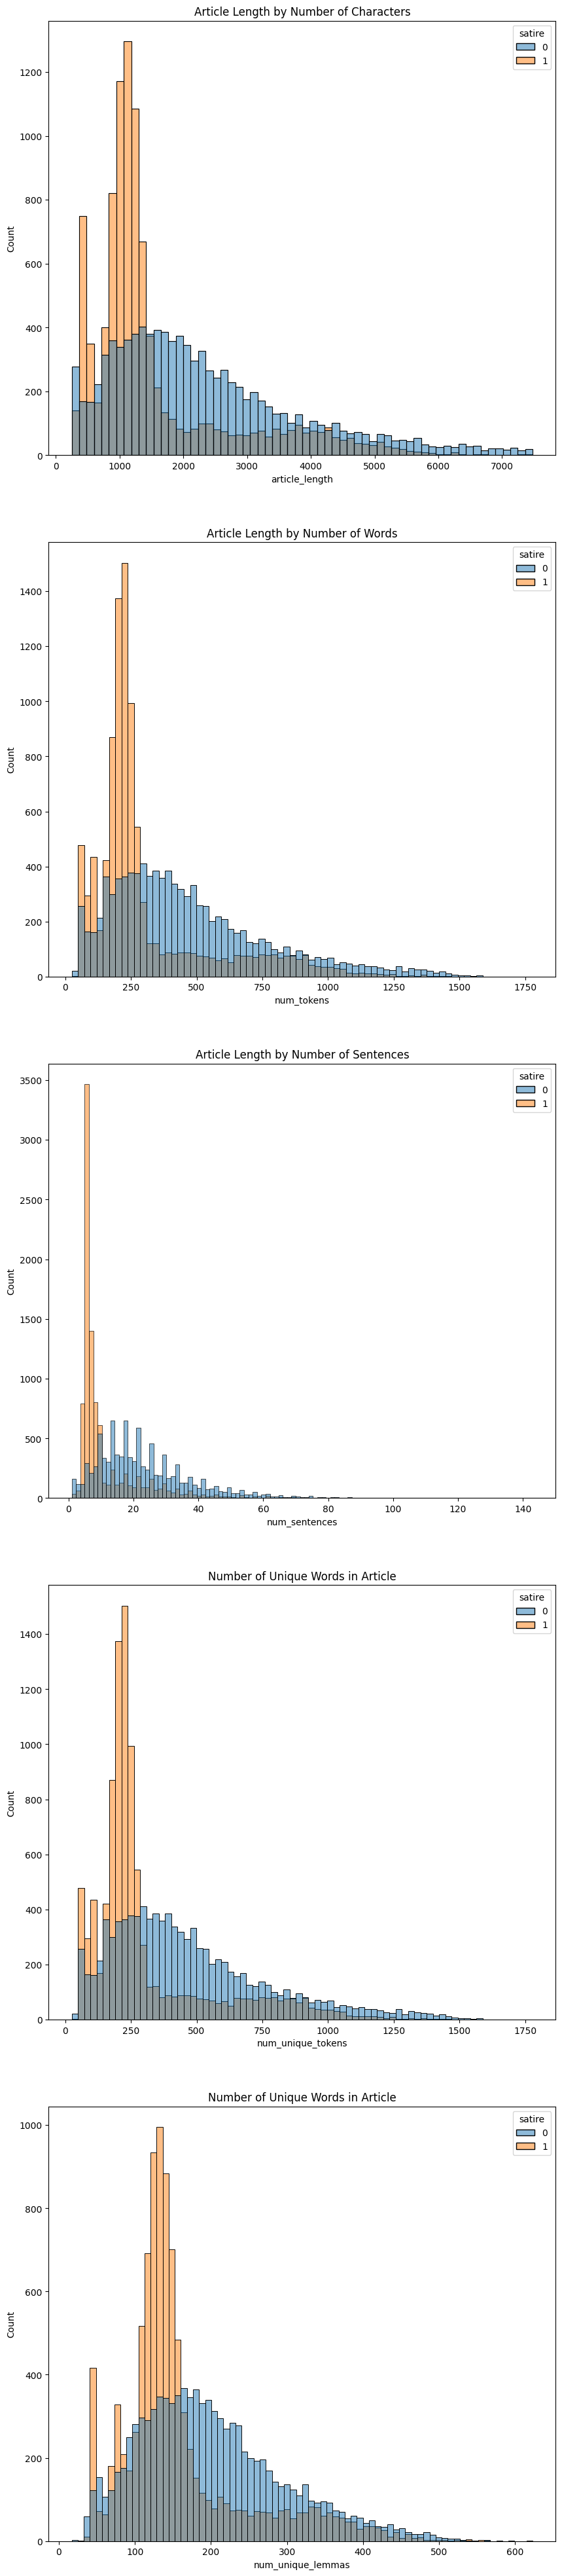

In [13]:
fig, axs = plt.subplots(5, 1)
fig.set_size_inches(10, 50)

sns.histplot(corpus, x="article_length", ax=axs[0], hue="satire")
axs[0].set_title("Article Length by Number of Characters")

sns.histplot(corpus, x="num_tokens", ax=axs[1], hue="satire")
axs[1].set_title("Article Length by Number of Words")

sns.histplot(corpus, x="num_sentences", ax=axs[2], hue="satire")
axs[2].set_title("Article Length by Number of Sentences")

sns.histplot(corpus, x="num_unique_tokens", ax=axs[3], hue="satire")
axs[3].set_title("Number of Unique Words in Article")

sns.histplot(corpus, x="num_unique_lemmas", ax=axs[4], hue="satire")
axs[4].set_title("Number of Unique Words in Article")

The distributions can't exactly be called similar, but they aren't drastically different, either. Both distributions are more frequently short than long, and both distributions have a tail extending to the right containing the minority of the posts. The satirical distribution is more extreme, but both distributions follow the same broad trend, so classification cannot be as simple as satirical articles being shorter.

Next, it will be a good idea to figure out what tokens are present in each category. The following cell will loop through each dataframe, tokenize the article, and accumulate a count for how many times that token has appeared for each dataframe. At the same time, the following will be excluded from the word counts:

* stop words (as defined by spaCy)
* punctuation
* whitespace
* words which aren't in spaCy's dictionary (this will exclude typos, made-up words, onomatopoeia, etc. from appearing)

In [14]:
token_counts = {}

N = len(onion_df)
M = len(not_onion_df)

for n, article in enumerate(onion_df["article_text"]):
    doc = nlp(article)

    for token in doc:
        if (
            not token.is_stop
            and not token.is_punct
            and not token.is_oov
            and not token.is_space
        ):
            token = str(token.lemma_).lower()
            if token not in token_counts:
                token_counts[token] = [0, 0]
            token_counts[token][0] += 1

    clear_output(wait=True)
    print(f"Onions iterated: {n + 1}/{N}\nNot Onions Iterated: {0}/{M}")

for m, article in enumerate(not_onion_df["article_text"]):
    doc = nlp(article)

    for token in doc:
        if (
            not token.is_stop
            and not token.is_punct
            and not token.is_oov
            and not token.is_space
        ):
            token = str(token.lemma_).lower()
            if token not in token_counts:
                token_counts[token] = [0, 0]
            token_counts[token][1] += 1

    clear_output(wait=True)
    print(f"Onions iterated: {N}/{N}\nNot Onions Iterated: {m + 1}/{M}")

Onions iterated: 9736/9736
Not Onions Iterated: 9736/9736


Next, we'll view the most common tokens in each dataset as well as its count.

Text(0.5, 1.0, 'Most Common Tokens in r/nottheonion')

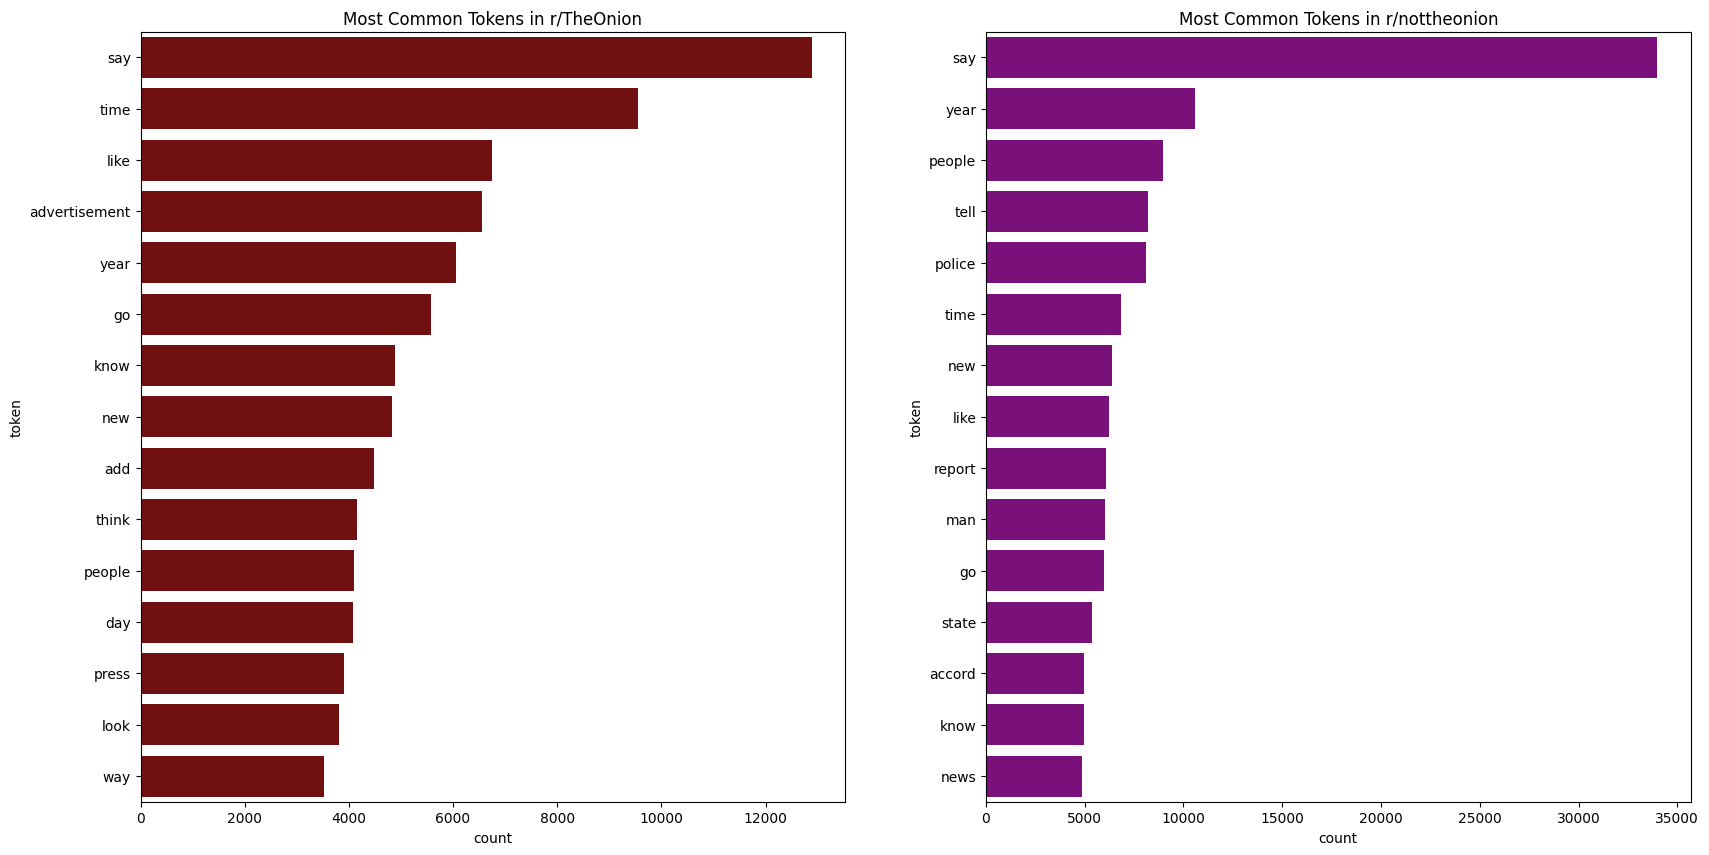

In [15]:
top_onion_tokens = list(
    islice(
        {
            k: v[0]
            for k, v in sorted(
                token_counts.items(), key=lambda x: 1.0 / (1.0 + x[1][0])
            )
        },
        15,
    )
)

top_onion_token_counts = pd.DataFrame()
top_onion_token_counts["token"] = [k for k in top_onion_tokens]
top_onion_token_counts["count"] = [token_counts[k][0] for k in top_onion_tokens]

top_nonion_tokens = list(
    islice(
        {
            k: v[1]
            for k, v in sorted(
                token_counts.items(), key=lambda x: 1.0 / (1.0 + x[1][1])
            )
        },
        15,
    )
)

top_nonion_token_counts = pd.DataFrame()
top_nonion_token_counts["token"] = [k for k in top_nonion_tokens]
top_nonion_token_counts["count"] = [token_counts[k][1] for k in top_nonion_tokens]

fig, axs = plt.subplots(1, 2)
fig.set_size_inches(20, 10)

sns.barplot(top_onion_token_counts, x="count", y="token", ax=axs[0], color="maroon")
sns.barplot(
    top_nonion_token_counts, x="count", y="token", ax=axs[1], color="darkmagenta"
)

axs[0].set_title("Most Common Tokens in r/TheOnion")
axs[1].set_title("Most Common Tokens in r/nottheonion")

While most of the highest-frequency tokens are unique between the two categories, there is some overlap. While it may be obvious to state that the word "advertisement" or "tell" occurs significantly more frequently in one category and thus should be considered as a word to filter out, it is less obvious to apply the same logic to "say", "year", or "people", as these words occur frequently in both categories. To rectify this, consider the following metric:

$$
\log(c_1 + c_2) \frac{c_1 - c_2}{c_1 + c_2},
$$

where $c_1$ and $c_2$ are the token counts in the first and second categories. This function has the following properties:

1. Tokens which are infrequent *or* occur in similar amounts between both categories will have small absolute values, and
2. Tokens which are frequent *and* occur much more in one category than the other will have large absolute values

What should be considered "large" is not yet clear and should be determined by the variance a model exhibits, but this metric allows me to ignore infrequent words while filtering out words which are very imbalanced between the two categories. Note that this metric is somewhat "muddy" for interpreting what any individual value means. The only things that can be said conclusively are the lower bound of the total token count, determined by the magnitude, and which category contains the token more, determined by the sign.

Text(0.5, 1.0, 'Most Imbalanced Tokens by Score Magnitude')

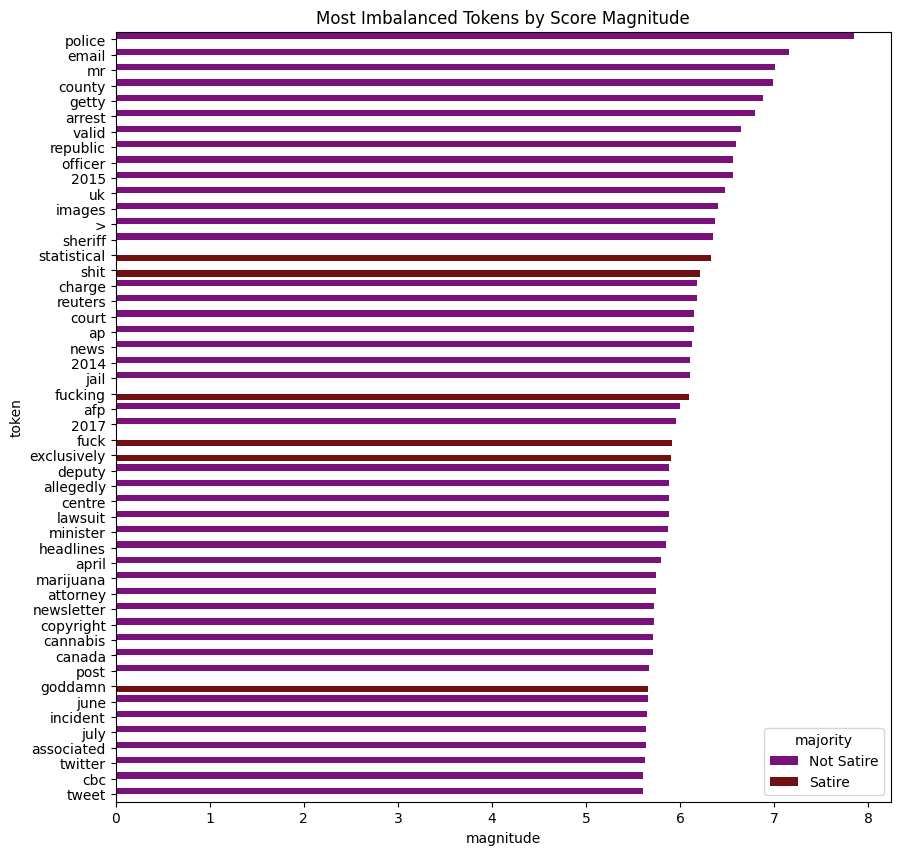

In [16]:
token_scores = {
    token: np.log(value[0] + value[1]) * (value[0] - value[1]) / (value[0] + value[1])
    for token, value in token_counts.items()
}

token_scores = {
    k: v for k, v in sorted(token_scores.items(), key=lambda x: 1.0 / (1.0 + x[1]))
}

token_scores_df = pd.DataFrame([])
token_scores_df["token"] = token_scores.keys()
token_scores_df["score"] = token_scores.values()

token_scores_df["magnitude"] = token_scores_df["score"].apply(np.abs)
token_scores_df["sign"] = token_scores_df["score"].apply(np.sign)
token_scores_df["majority"] = token_scores_df["sign"].apply(
    lambda x: "Satire" if x == 1 else "Not Satire"
)

token_scores_df = token_scores_df.sort_values(by="magnitude", ascending=False)

fig, ax = plt.subplots()
fig.set_size_inches(10, 10)

sns.barplot(
    token_scores_df.head(50),
    x="magnitude",
    y="token",
    hue="majority",
    ax=ax,
    palette={"Satire": "maroon", "Not Satire": "darkmagenta"},
)

ax.set_title("Most Imbalanced Tokens by Score Magnitude")

As should be expected, most of the terms with high absolute scores are non-satirical, which is most likely due to the fact that the non-satirical category contains about 50% more tokens. Excepting that, this scoring metric makes problematic terms much more obvious. First and foremost, profanity. While I will not explicitly be removing profane words, they are much more common in articles published by The Onion. Secondly, and more importantly from a human perspective, the names of news publishers are present such as "reuters", "ap news", and "cbc" are present. As a person, I can trivially see the name *Reuters* and know, with very high confidence, that it's a real news article. So luckily, it seems that this metric is able to notice this, and filter them out if a score-threshold is applied. For intuition, remember that the score is logarithmic, and thus a token with an absolute score of 6 occurs *at least* about 400 times combined. 

So, if filtering were applied, what would the effects be?

Text(0.5, 1.0, 'Effective Corpus Size vs Score Threshold')

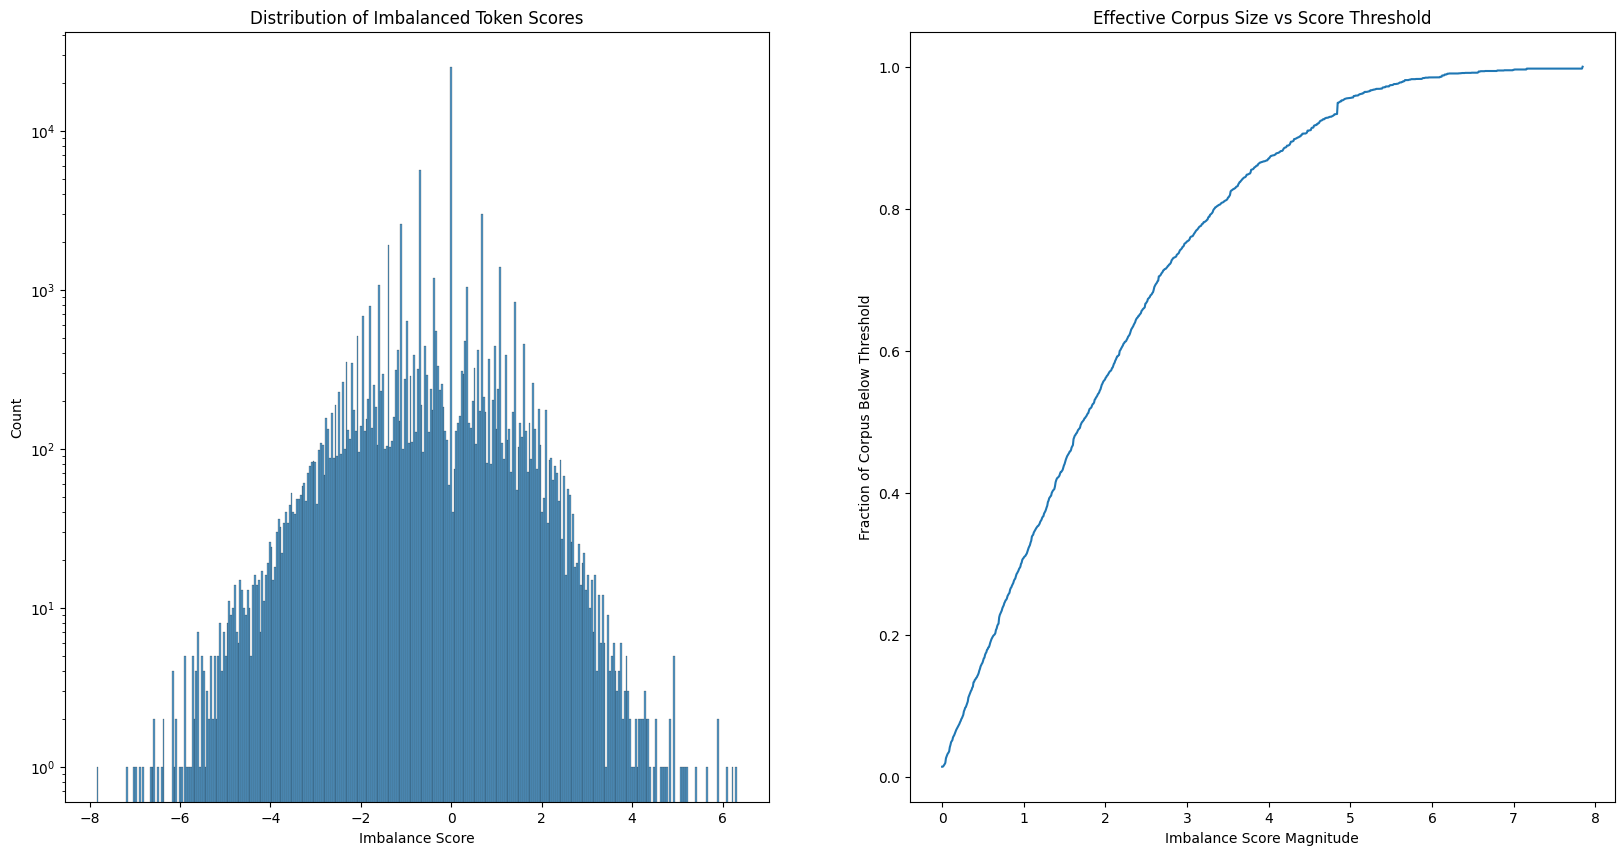

In [17]:
fig, axs = plt.subplots(1, 2)
fig.set_size_inches(20, 10)

sns.histplot(list(token_scores.values()), ax=axs[0])
axs[0].set_yscale("log")

thresh = np.linspace(0, max(np.abs(list(token_scores.values()))), 1000)

corpus_sizes = []

for t in thresh:
    corpus_sizes.append(
        np.sum(
            [
                token_counts[token][0] + token_counts[token][1]
                for token in token_scores
                if np.abs(token_scores[token]) <= t
            ]
        )
    )

corpus_sizes = np.array(corpus_sizes) / np.max(corpus_sizes)

sns.lineplot(x=thresh, y=corpus_sizes, ax=axs[1])

axs[0].set_xlabel("Imbalance Score")
axs[0].set_title("Distribution of Imbalanced Token Scores")

axs[1].set_xlabel("Imbalance Score Magnitude")
axs[1].set_ylabel("Fraction of Corpus Below Threshold")
axs[1].set_title("Effective Corpus Size vs Score Threshold")

By the scoring method implemented, there are more tokens that appear frequently in the non-satirical category, which again is likely due to the fact that that category is larger to begin with. However, it is now clear that the vast majority of tokens appear in a relatively balanced manner. A large percentage of the tokens have a score between negative and positive three, which, as my intuition currently stands, corresponds to well-balanced data. A score of three implies the token occurs at least 20 times, but if it occured, say, 10,000 times, then it would occur only a few thousand times more in one category than the other, which is far from being unique to one category.

As such, lower thresholds are much more severe than higher thresholds. A threshold of one would only utilize about 20% of the words, while a threshold of two would utilize closer to 50%, and a threshold of 5.0 would use 95.6% of the words included in the corpus. It is unclear at this point what an effective threshold would be, but based on my intuition, raising the threshold would lead to lower bias and higher variance.

# Sentiment EDA

Real, quality news articles try to be unbiased, and as such they will often avoid using polarizing language. Satire makes no such effort, for the most part, and therefore there may be a stark difference in the distribution of sentiment values for the two categories. spaCy makes two such sentiment values available for each token: polarity and subjectivity. Polarity being how "good" or "bad" a word is, and subjectivity being how much that word is usually associated with opinions. The following two cells will calculate the sentiment values for each article, and then plot the distributions.

In [18]:
N = len(onion_df)
M = len(not_onion_df)

onion_polarity = []
not_onion_polarity = []

onion_subjectivity = []
not_onion_subjectivity = []

for n, article in enumerate(onion_df["article_text"]):
    doc = nlp(article)

    onion_polarity.append(doc._.blob.polarity)
    onion_subjectivity.append(doc._.blob.subjectivity)

    clear_output(wait=True)
    print(f"Onions iterated: {n + 1}/{N}\nNot Onions Iterated: {0}/{M}")

for m, article in enumerate(not_onion_df["article_text"]):
    doc = nlp(article)

    not_onion_polarity.append(doc._.blob.polarity)
    not_onion_subjectivity.append(doc._.blob.subjectivity)

    clear_output(wait=True)
    print(f"Onions iterated: {N}/{N}\nNot Onions Iterated: {m + 1}/{M}")

Onions iterated: 9736/9736
Not Onions Iterated: 9736/9736


Text(0.5, 1.0, 'Non-Satire Subjectivity')

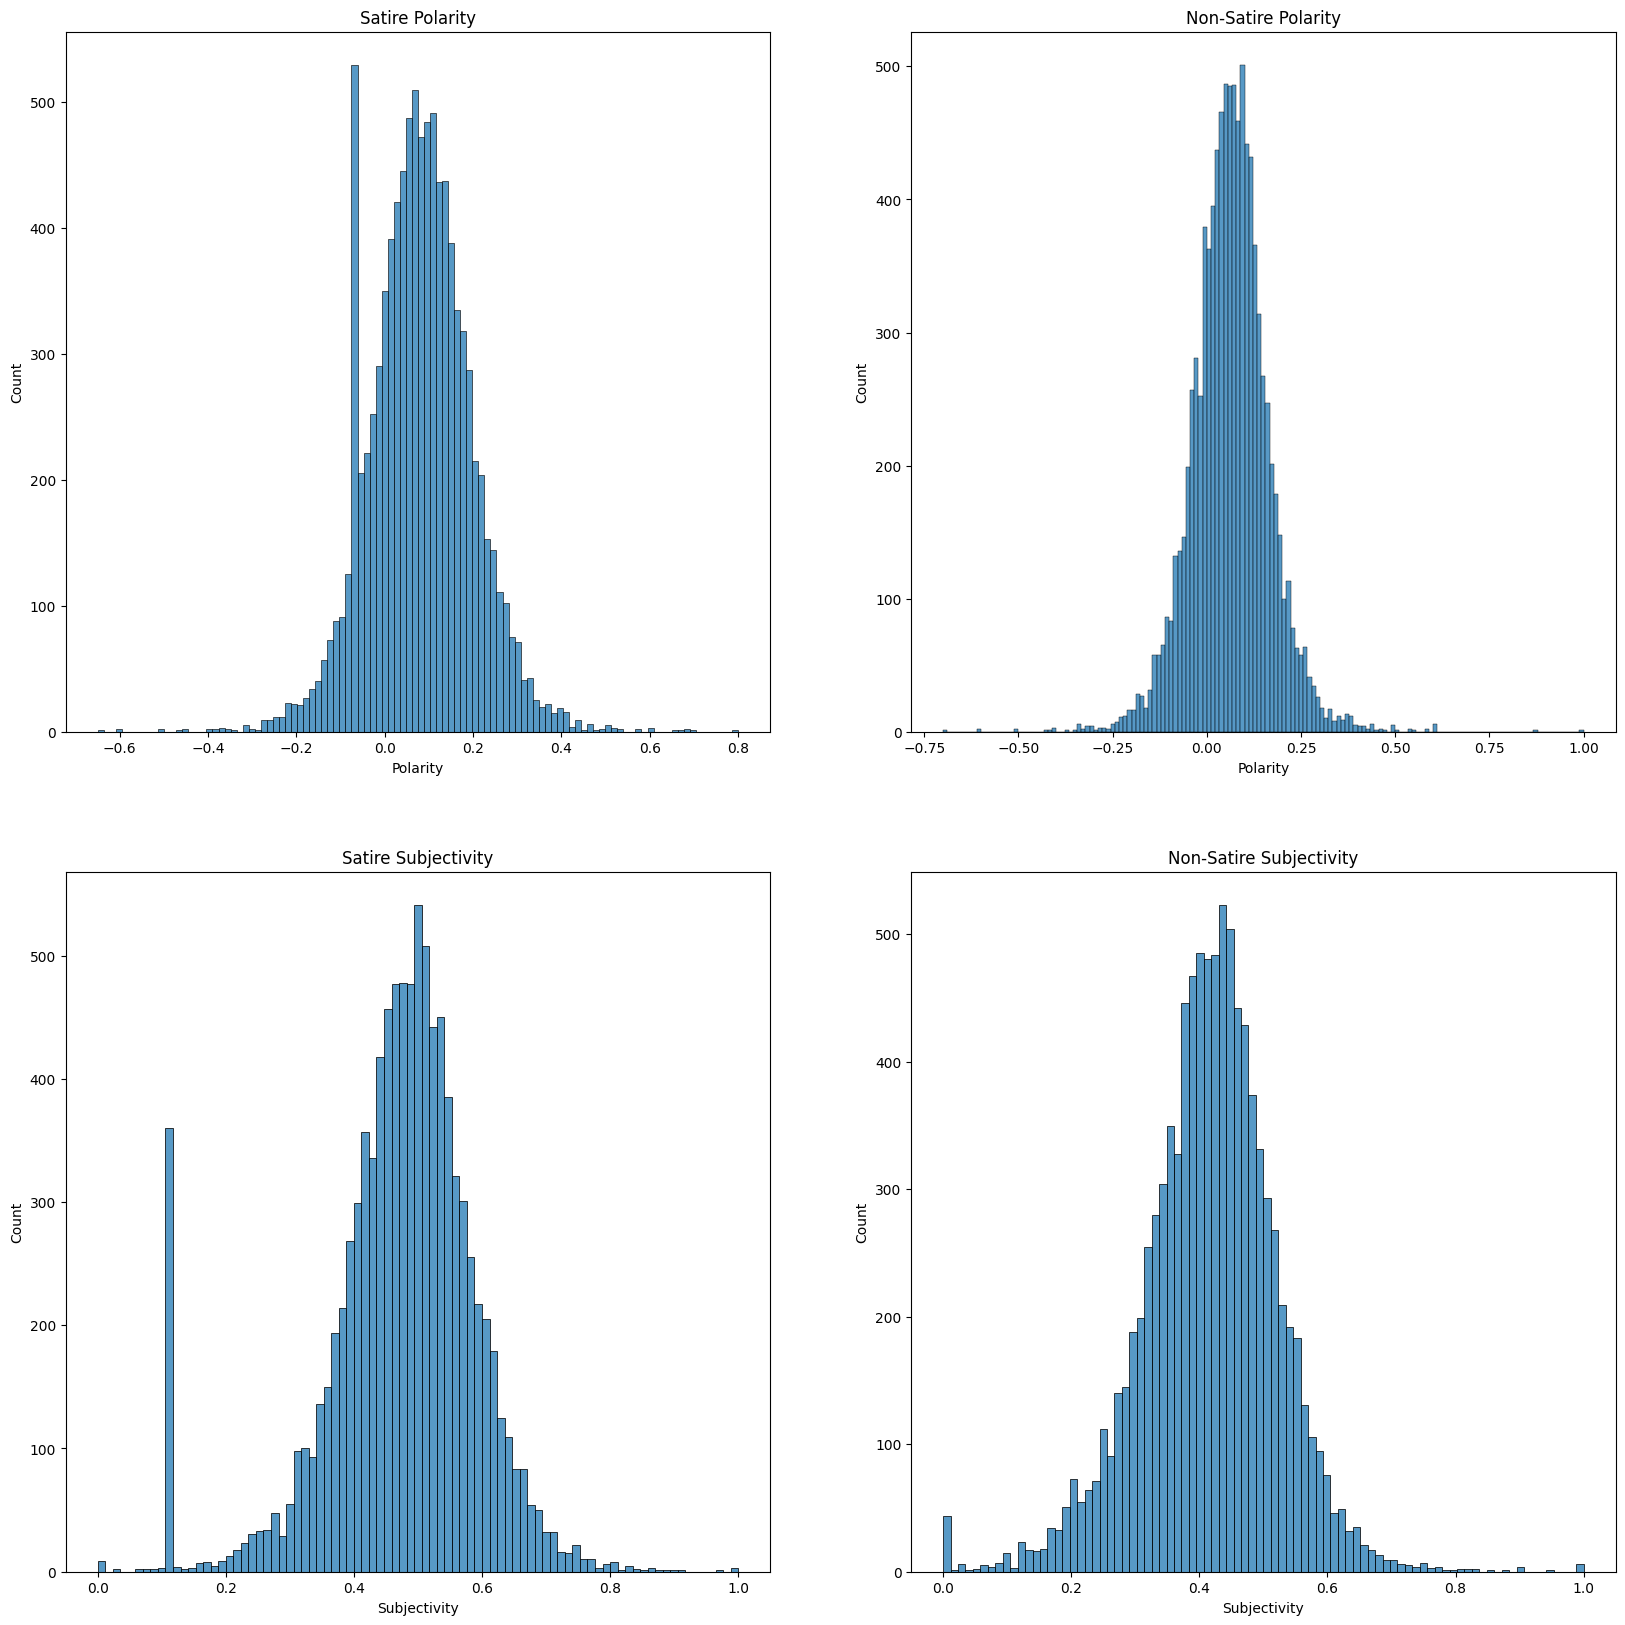

In [19]:
fig, axs = plt.subplots(2, 2)
fig.set_size_inches(20, 20)

sns.histplot(onion_polarity, ax=axs[0, 0])
axs[0, 0].set_xlabel("Polarity")
axs[0, 0].set_title("Satire Polarity")

sns.histplot(not_onion_polarity, ax=axs[0, 1])
axs[0, 1].set_xlabel("Polarity")
axs[0, 1].set_title("Non-Satire Polarity")

sns.histplot(onion_subjectivity, ax=axs[1, 0])
axs[1, 0].set_xlabel("Subjectivity")
axs[1, 0].set_title("Satire Subjectivity")

sns.histplot(not_onion_subjectivity, ax=axs[1, 1])
axs[1, 1].set_xlabel("Subjectivity")
axs[1, 1].set_title("Non-Satire Subjectivity")

The distributions are not drastically different, so in the interest in not feeding the model an excessive amount of data (and therefore allowing fitting to finish in a reasonable amount of time), sentiment data will not be included in model fitting.

Finally, the data is saved for use in training.

In [20]:
corpus.to_csv("../data/corpus.csv", index=False)